In [1]:
!nvidia-smi

Fri Sep 29 14:50:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P5               12W / 170W|    670MiB / 12288MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from scipy import stats
import sklearn

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10


print("TensorFlow version:", tf.__version__)
print("scikit-learn version:", sklearn.__version__)

TensorFlow version: 2.10.1
scikit-learn version: 1.2.2


In [3]:
data_raw = pd.read_csv('sensors.csv')
data_raw['types'] = np.where(data_raw['type']=='CarbonDioxide', '0','1')
data_raw = data_raw[data_raw['type']=='CarbonDioxide']
zero_base = data_raw[data_raw['v'] == 0].index
data_raw.drop(zero_base, axis = 0, inplace = True)
data_raw.reset_index(drop=True, inplace=True)


data_gs116_794B44 = data_raw[data_raw['device']== 'gs116_794B44']   # Device 3
data_gs116_794B44 = data_gs116_794B44.drop_duplicates(['ts'], keep='first')



# # Ts, v only data

data_gs116_794B44_original = data_gs116_794B44.loc[:, ['ts','v']]
data_gs116_794B44_original.reset_index(drop=True, inplace=True)

In [4]:
data_gs116_794B44_original

,ts,v
0,2023-01-15 00:00:04.000000,415.0
1,2023-01-15 00:00:34.000000,415.0
2,2023-01-15 00:01:04.000000,415.0
3,2023-01-15 00:01:34.000000,415.0
4,2023-01-15 00:02:04.000000,415.0
...,...,...
507565,2023-03-04 23:57:54.000000,406.0
507566,2023-03-04 23:58:24.000000,406.0
507567,2023-03-04 23:58:54.000000,406.0
507568,2023-03-04 23:59:24.000000,405.0


In [5]:
data_gs116_794B44_index = data_gs116_794B44_original.set_index('ts')
data_gs116_794B44_index

,v
ts,
2023-01-15 00:00:04.000000,415.0
2023-01-15 00:00:34.000000,415.0
2023-01-15 00:01:04.000000,415.0
2023-01-15 00:01:34.000000,415.0
2023-01-15 00:02:04.000000,415.0
...,...
2023-03-04 23:57:54.000000,406.0
2023-03-04 23:58:24.000000,406.0
2023-03-04 23:58:54.000000,406.0


In [6]:
data_gs116_794B44_traintest = data_gs116_794B44_index.sort_values(by = 'ts', ascending= True)
data_gs116_794B44_traintest

,v
ts,
2022-10-10 04:11:58.000000,560.0
2022-10-10 04:16:58.000000,547.0
2022-10-10 04:21:58.000000,578.0
2022-10-10 04:26:58.000000,548.0
2022-10-10 04:31:58.000000,571.0
...,...
2023-04-05 05:25:03.000000,830.0
2023-04-05 05:25:33.000000,830.0
2023-04-05 05:26:03.000000,829.0


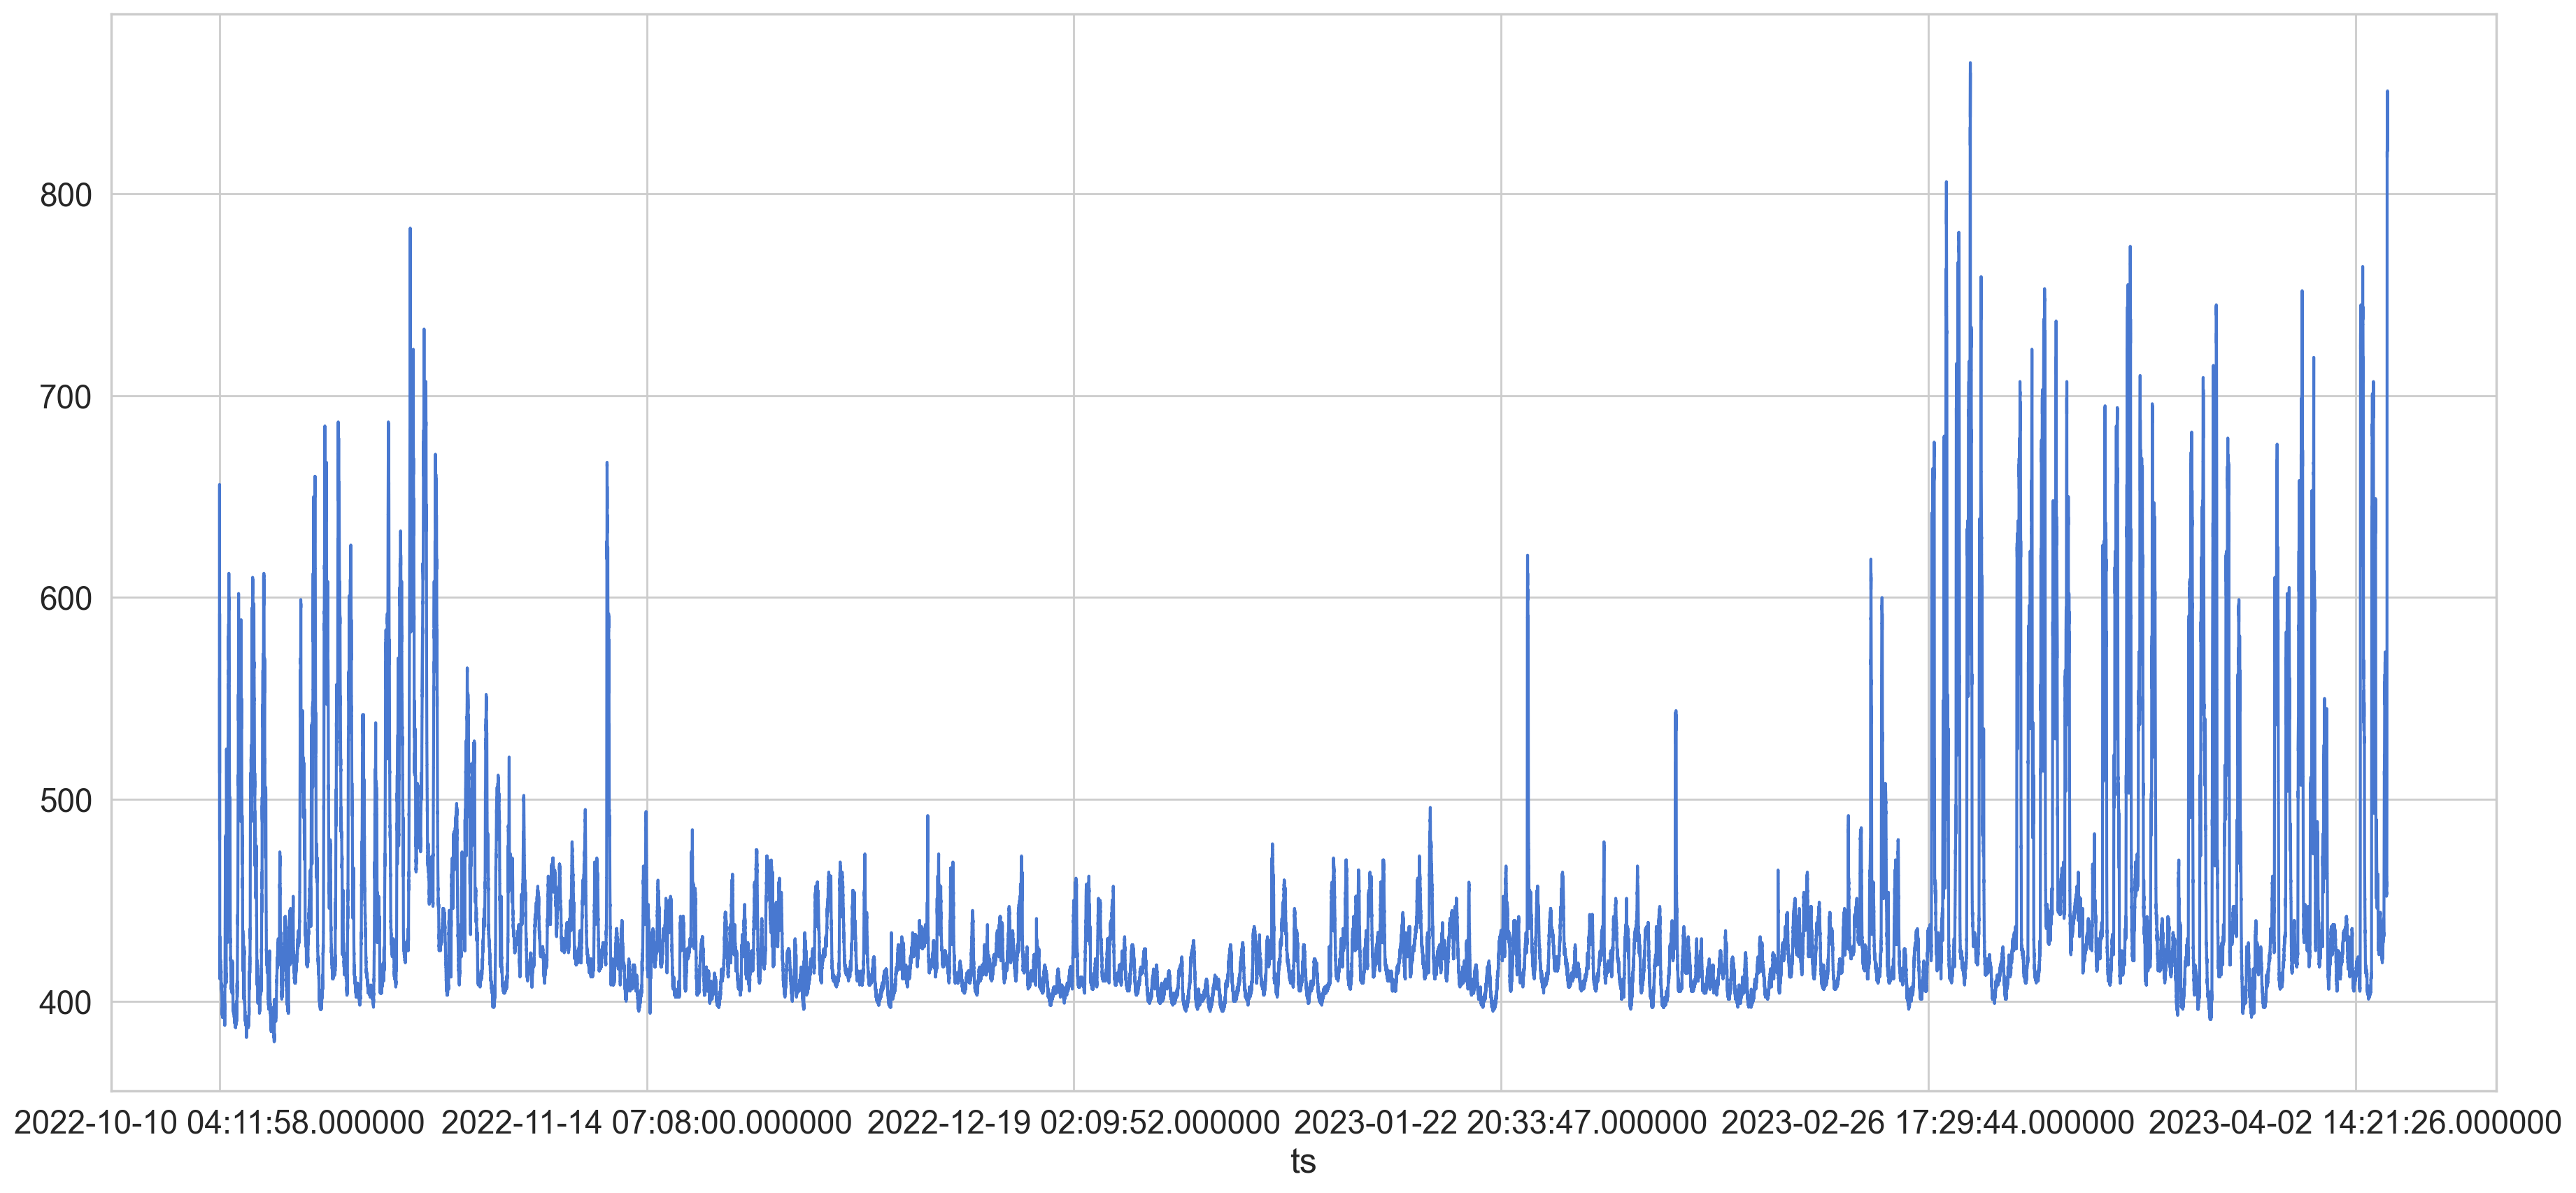

In [7]:
fig, ax = plt.subplots()
data_gs116_794B44_traintest.plot(legend = False, ax = ax)
plt.show()

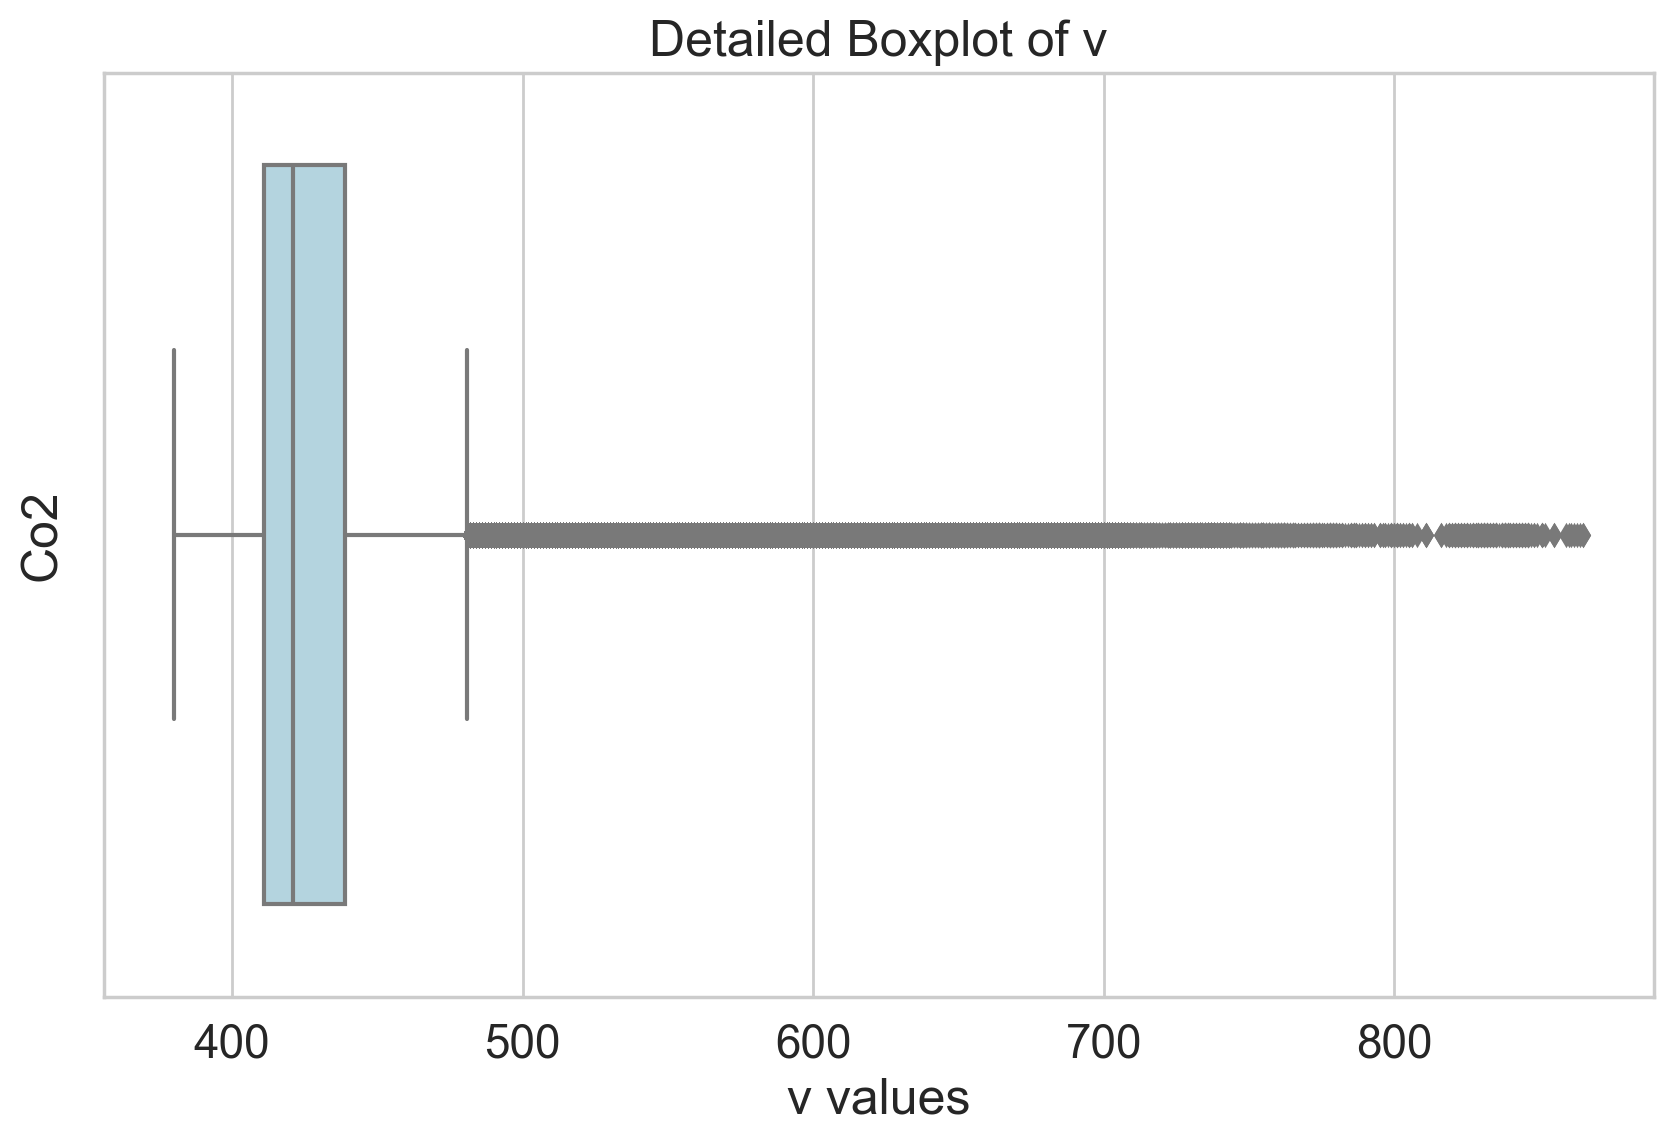

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_gs116_794B44_traintest['v'], color='lightblue')
plt.title('Detailed Boxplot of v')
plt.xlabel('v values')
plt.ylabel('Co2')

# Calculate IQR and quartiles
Q1 = data_gs116_794B44_traintest['v'].quantile(0.25)
Q3 = data_gs116_794B44_traintest['v'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Annotate the boxplot with the whisker, median, and quartile values
plt.annotate(f'Upper Whisker: {upper_bound:.2f}', xy=(0.95, upper_bound), xytext=(0.5, upper_bound+2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.annotate(f'Q3: {Q3:.2f}', xy=(0.95, Q3), xytext=(0.5, Q3+2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.annotate(f'Median: {data_gs116_794B44_traintest["v"].median():.2f}', xy=(0.95, data_gs116_794B44_traintest["v"].median()), 
             xytext=(0.5, data_gs116_794B44_traintest["v"].median()-4),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.annotate(f'Q1: {Q1:.2f}', xy=(0.95, Q1), xytext=(0.5, Q1-4),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.annotate(f'Lower Whisker: {lower_bound:.2f}', xy=(0.95, lower_bound), xytext=(0.5, lower_bound-2),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')

plt.show()

In [9]:
# Count outliers
outliers = data_gs116_794B44_traintest[(data_gs116_794B44_traintest['v'] < lower_bound) | (data_gs116_794B44_traintest['v'] > upper_bound)]
num_outliers = len(outliers)

print(f"Number of potential anomalies: {num_outliers}")

Number of potential anomalies: 54835


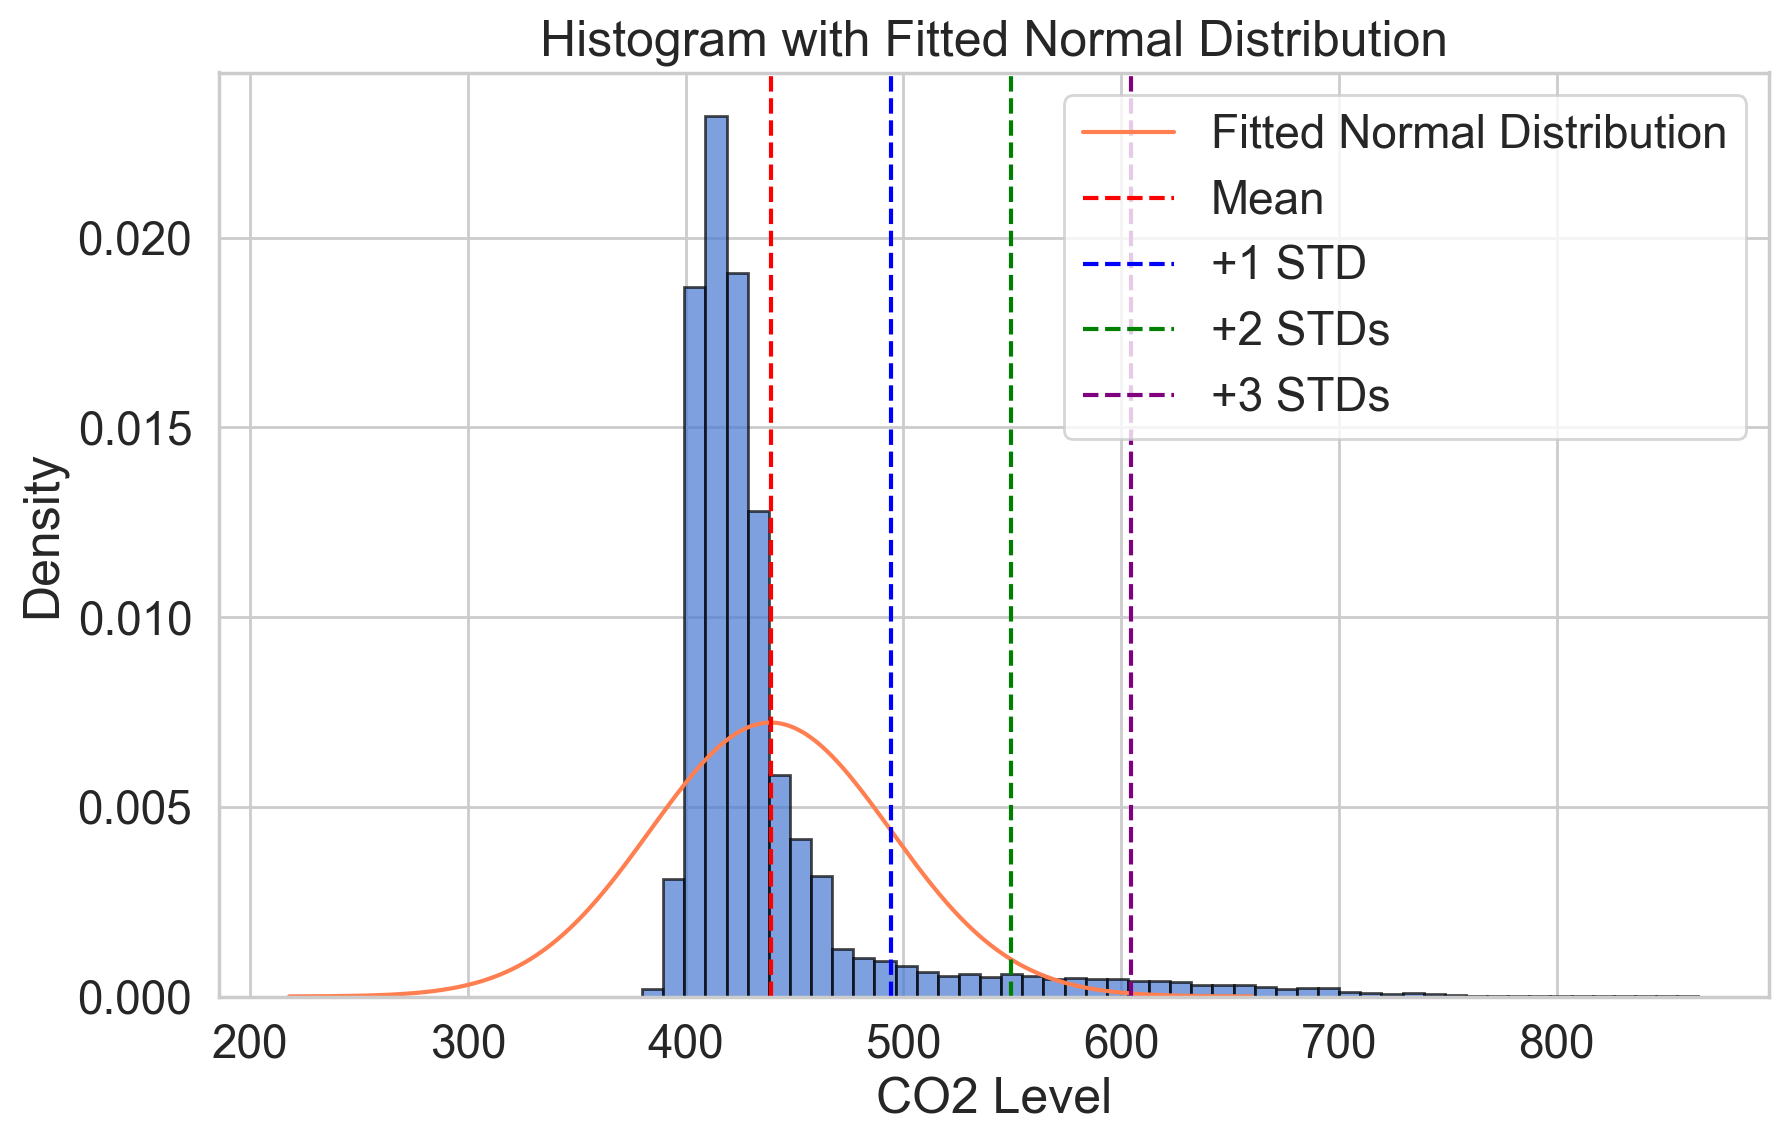

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Given data
mean_val = data_gs116_794B44_traintest['v'].mean()
std_val = data_gs116_794B44_traintest['v'].std()

# Generate values for the fitted curve
x = np.linspace(mean_val - 4*std_val, mean_val + 4*std_val, 1000)
y = norm.pdf(x, mean_val, std_val)

plt.figure(figsize=(10, 6))
data_gs116_794B44_traintest['v'].hist(bins=50, edgecolor='black', alpha=0.7, density=True) # Note: 'density=True' normalizes the histogram
plt.plot(x, y, color='coral', label='Fitted Normal Distribution')

# Your existing code for vertical lines
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label='Mean')
plt.axvline(mean_val + std_val, color='blue', linestyle='dashed', linewidth=1.5, label='+1 STD')
plt.axvline(mean_val + 2*std_val, color='green', linestyle='dashed', linewidth=1.5, label='+2 STDs')
plt.axvline(mean_val + 3*std_val, color='purple', linestyle='dashed', linewidth=1.5, label='+3 STDs')

# Legend to describe the lines
plt.legend()

plt.title('Histogram with Fitted Normal Distribution')
plt.xlabel('CO2 Level')
plt.ylabel('Density')
plt.grid(True)
plt.show()

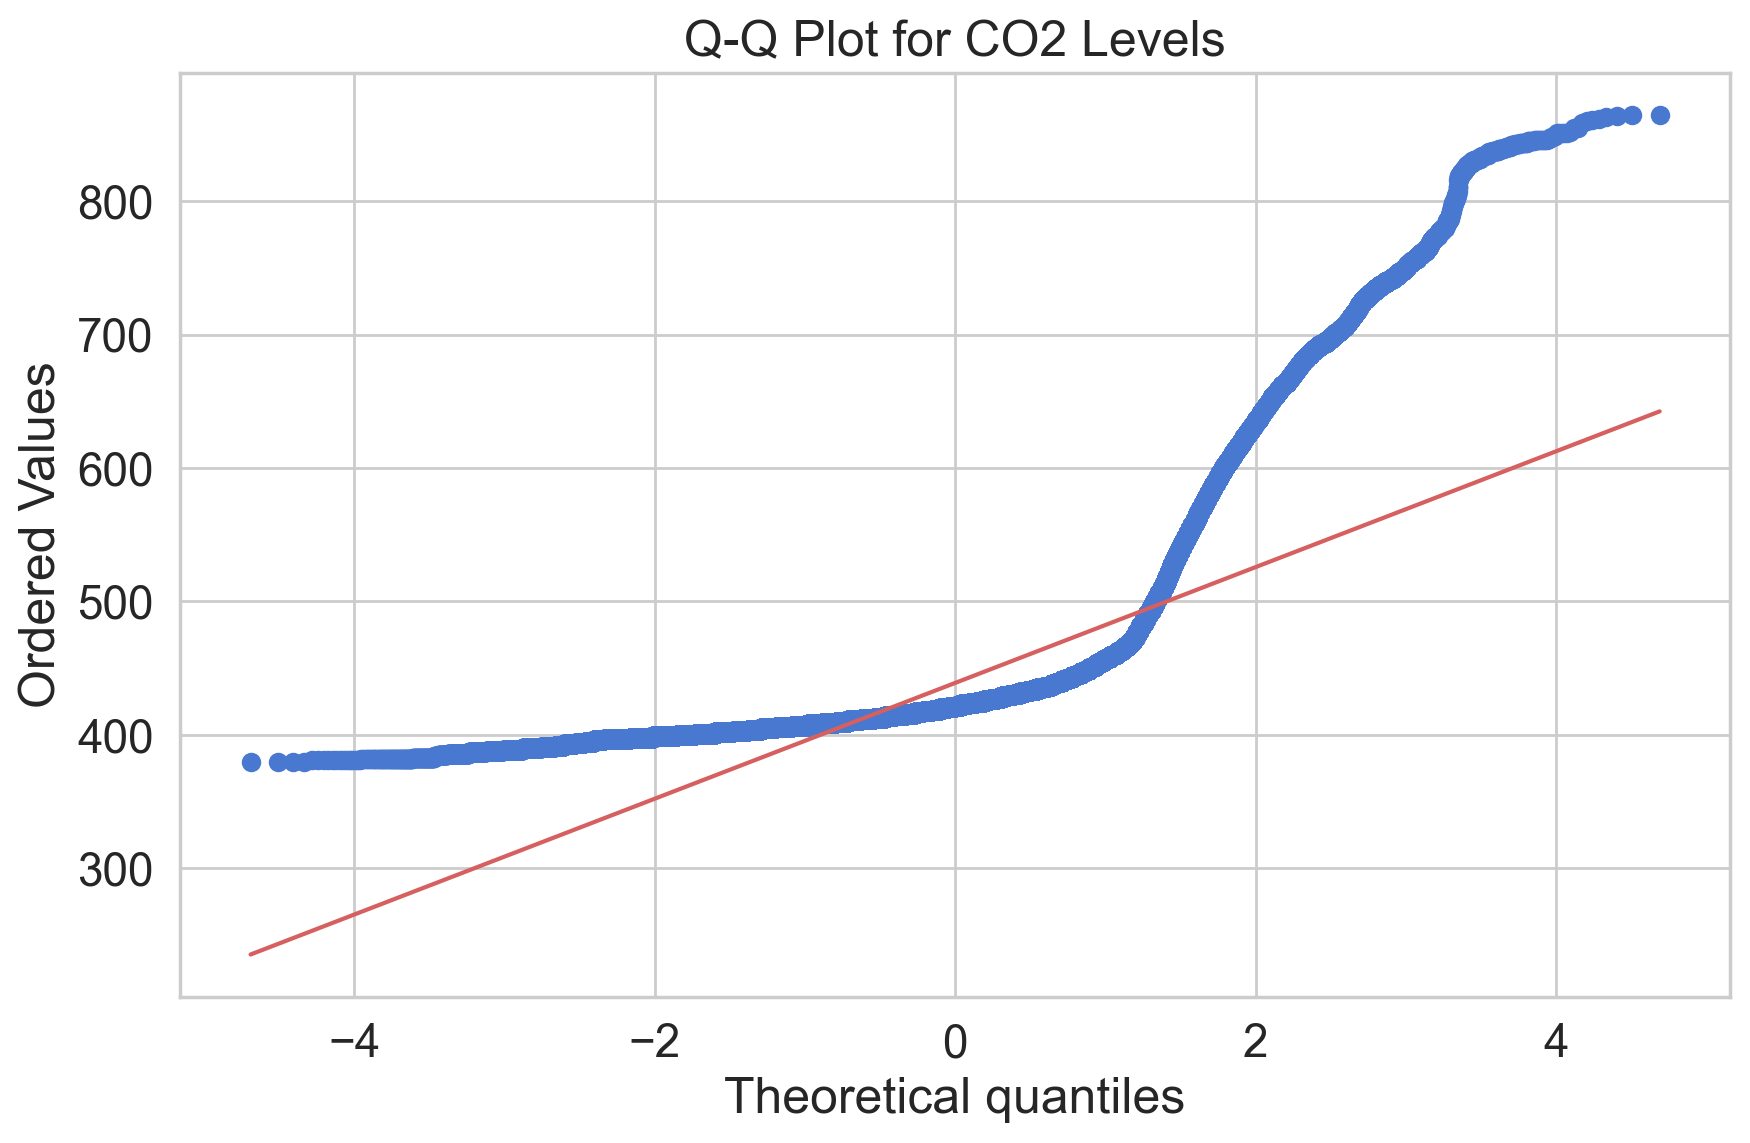

In [11]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(data_gs116_794B44_traintest['v'], dist="norm", plot=plt)
plt.title('Q-Q Plot for CO2 Levels')
plt.show()

In [12]:
# Convert the 'ts' index to datetime format if it's not already
data_gs116_794B44_traintest.index = pd.to_datetime(data_gs116_794B44_traintest.index)

# Split the data into training and test sets based on the provided timestamps
train_data = data_gs116_794B44_traintest['2022-10-10 04:11:58':'2023-03-18 23:59:59']
test_data = data_gs116_794B44_traintest['2023-03-19 00:00:00':'2023-04-05 05:27:03']


# Calculate mean and standard deviation
mean_val_whole = data_gs116_794B44_traintest['v'].mean()
std_val_whole = data_gs116_794B44_traintest['v'].std()

# Calculate the bounds for 2 standard deviations
lower_bound_whole = mean_val_whole - 2 * std_val_whole
upper_bound_whole = mean_val_whole + 2 * std_val_whole


print(train_data)
print(test_data)

                         v
ts                        
2022-10-10 04:11:58  560.0
2022-10-10 04:16:58  547.0
2022-10-10 04:21:58  578.0
2022-10-10 04:26:58  548.0
2022-10-10 04:31:58  571.0
...                    ...
2023-03-24 23:57:42  403.0
2023-03-24 23:58:12  403.0
2023-03-24 23:58:42  403.0
2023-03-24 23:59:12  403.0
2023-03-24 23:59:42  402.0

[475275 rows x 1 columns]
                         v
ts                        
2023-03-25 00:00:12  402.0
2023-03-25 00:00:42  402.0
2023-03-25 00:01:12  402.0
2023-03-25 00:01:42  402.0
2023-03-25 00:02:12  402.0
...                    ...
2023-04-05 05:25:03  830.0
2023-04-05 05:25:33  830.0
2023-04-05 05:26:03  829.0
2023-04-05 05:26:33  829.0
2023-04-05 05:27:03  828.0

[32295 rows x 1 columns]


In [13]:
# Calculate mean and standard deviation
mean_val_train = train_data['v'].mean()
std_val_train = train_data['v'].std()

# Calculate the bounds for 2 standard deviations
lower_bound_train = mean_val_train - 2 * std_val_train
upper_bound_train = mean_val_train + 2 * std_val_train

# Filter out anomalies that are both above the upper bound and below the lower bound
filtered_train = train_data[(train_data['v'] <= upper_bound_whole)]

In [14]:
filtered_train

,v
ts,
2022-10-10 04:16:58,547.0
2022-10-10 04:26:58,548.0
2022-10-10 05:01:58,542.0
2022-10-10 05:06:58,545.0
2022-10-10 05:11:58,502.0
...,...
2023-03-24 23:57:42,403.0
2023-03-24 23:58:12,403.0
2023-03-24 23:58:42,403.0


In [15]:
# Calculate mean and standard deviation
mean_val_test = test_data['v'].mean()
std_val_test = test_data['v'].std()

# Calculate the bounds for 2 standard deviations
lower_bound_test = mean_val_test - 2 * std_val_test
upper_bound_test = mean_val_test + 2 * std_val_test

# Filter out anomalies that are both above the upper bound and below the lower bound
filtered_test = test_data[(test_data['v'] <= upper_bound_whole)]

In [16]:
filtered_test

,v
ts,
2023-03-25 00:00:12,402.0
2023-03-25 00:00:42,402.0
2023-03-25 00:01:12,402.0
2023-03-25 00:01:42,402.0
2023-03-25 00:02:12,402.0
...,...
2023-04-05 03:52:33,515.0
2023-04-05 03:53:03,524.0
2023-04-05 03:53:33,533.0


In [17]:
# Similarly, create a 'label' column for the test data
test_data['label'] = np.where((test_data['v'] <= upper_bound_whole), 0, 1)

C:\Users\user\AppData\Local\Temp\ipykernel_17912\647677219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = np.where((test_data['v'] <= upper_bound_whole), 0, 1)


In [18]:
train, test = filtered_train,test_data
print(train.shape, test.shape)

(449122, 1) (32295, 2)


In [19]:
from sklearn.preprocessing import StandardScaler

# Ensure you're working on copies of the original data
train_copy = train.copy()
test_copy = test.copy()

scaler = StandardScaler()
scaler.fit(train_copy[['v']])

# Transform the training and test data
train_copy['v'] = scaler.transform(train_copy[['v']])
test_copy['v'] = scaler.transform(test_copy[['v']])

In [20]:
test_copy

,v,label
ts,,
2023-03-25 00:00:12,-0.957103,0
2023-03-25 00:00:42,-0.957103,0
2023-03-25 00:01:12,-0.957103,0
2023-03-25 00:01:42,-0.957103,0
2023-03-25 00:02:12,-0.957103,0
...,...,...
2023-04-05 05:25:03,15.816929,1
2023-04-05 05:25:33,15.816929,1
2023-04-05 05:26:03,15.777737,1


In [21]:
train_copy

,v
ts,
2022-10-10 04:16:58,4.725688
2022-10-10 04:26:58,4.764880
2022-10-10 05:01:58,4.529730
2022-10-10 05:06:58,4.647305
2022-10-10 05:11:58,2.962063
...,...
2023-03-24 23:57:42,-0.917912
2023-03-24 23:58:12,-0.917912
2023-03-24 23:58:42,-0.917912


In [22]:
def create_sequences(data, seq_length):
    sequences = []
    target = []
    
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
        
    return np.array(sequences)

In [23]:
# Define sequence length
seg_length = 30  # for example, using 24 hours of data

# Reshape training and test data
train_sequences = create_sequences(train_copy['v'].values, seg_length)
test_sequences = create_sequences(test_copy['v'].values, seg_length)

In [24]:
# Reshape sequences for LSTM input
train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

In [25]:
# lstm autoencoder to recreate a timeseries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import Dropout
from keras.layers import TimeDistributed

In [26]:
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
units_list = [16]  # For now, I'm using 1 layer with 16 units. You can add more if needed.
input_shape = (30, 1)  # As per your dataset shape
dropout_rate = 0.2
learning_rate = 1e-05

# Initialize the model
model = Sequential()

#Encoder
for i, units in enumerate(units_list):
    return_sequences = True if i < len(units_list) - 1 else False
    if i == 0:
        # For the first layer, you need to specify the input shape.
        model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=return_sequences))
    else:
        model.add(LSTM(units, activation='tanh', return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))

# Add RepeatVector layer
model.add(RepeatVector(input_shape[0]))

# Decoder
for units in reversed(units_list):
    model.add(LSTM(units, activation='tanh', return_sequences=True))
    model.add(Dropout(dropout_rate))

# Add TimeDistributed layer
model.add(TimeDistributed(Dense(input_shape[1])))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1152      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 16)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 16)            2112      
                                                                 
 dropout_1 (Dropout)         (None, 30, 16)            0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            17        
 ibuted)                                                

In [27]:
epochs = 30  # The number of times the model will iterate over the entire training dataset.
batch_size = 64  # The number of samples per gradient update.

history = model.fit(train_sequences, train_sequences, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/30
6316/6316 [==============================] - 70s 10ms/step - loss: 0.2674 - val_loss: 0.1971
Epoch 2/30
6316/6316 [==============================] - 64s 10ms/step - loss: 0.0837 - val_loss: 0.0853
Epoch 3/30
6316/6316 [==============================] - 64s 10ms/step - loss: 0.0611 - val_loss: 0.0618
Epoch 4/30
6316/6316 [==============================] - 64s 10ms/step - loss: 0.0513 - val_loss: 0.0504
Epoch 5/30
6316/6316 [==============================] - 63s 10ms/step - loss: 0.0452 - val_loss: 0.0430
Epoch 6/30
6316/6316 [==============================] - 59s 9ms/step - loss: 0.0412 - val_loss: 0.0374
Epoch 7/30
6316/6316 [==============================] - 63s 10ms/step - loss: 0.0383 - val_loss: 0.0336
Epoch 8/30
6316/6316 [==============================] - 64s 10ms/step - loss: 0.0362 - val_loss: 0.0309
Epoch 9/30
6316/6316 [==============================] - 63s 10ms/step - loss: 0.0346 - val_loss: 0.0292
Epoch 10/30
6316/6316 [==============================] - 63s 10ms

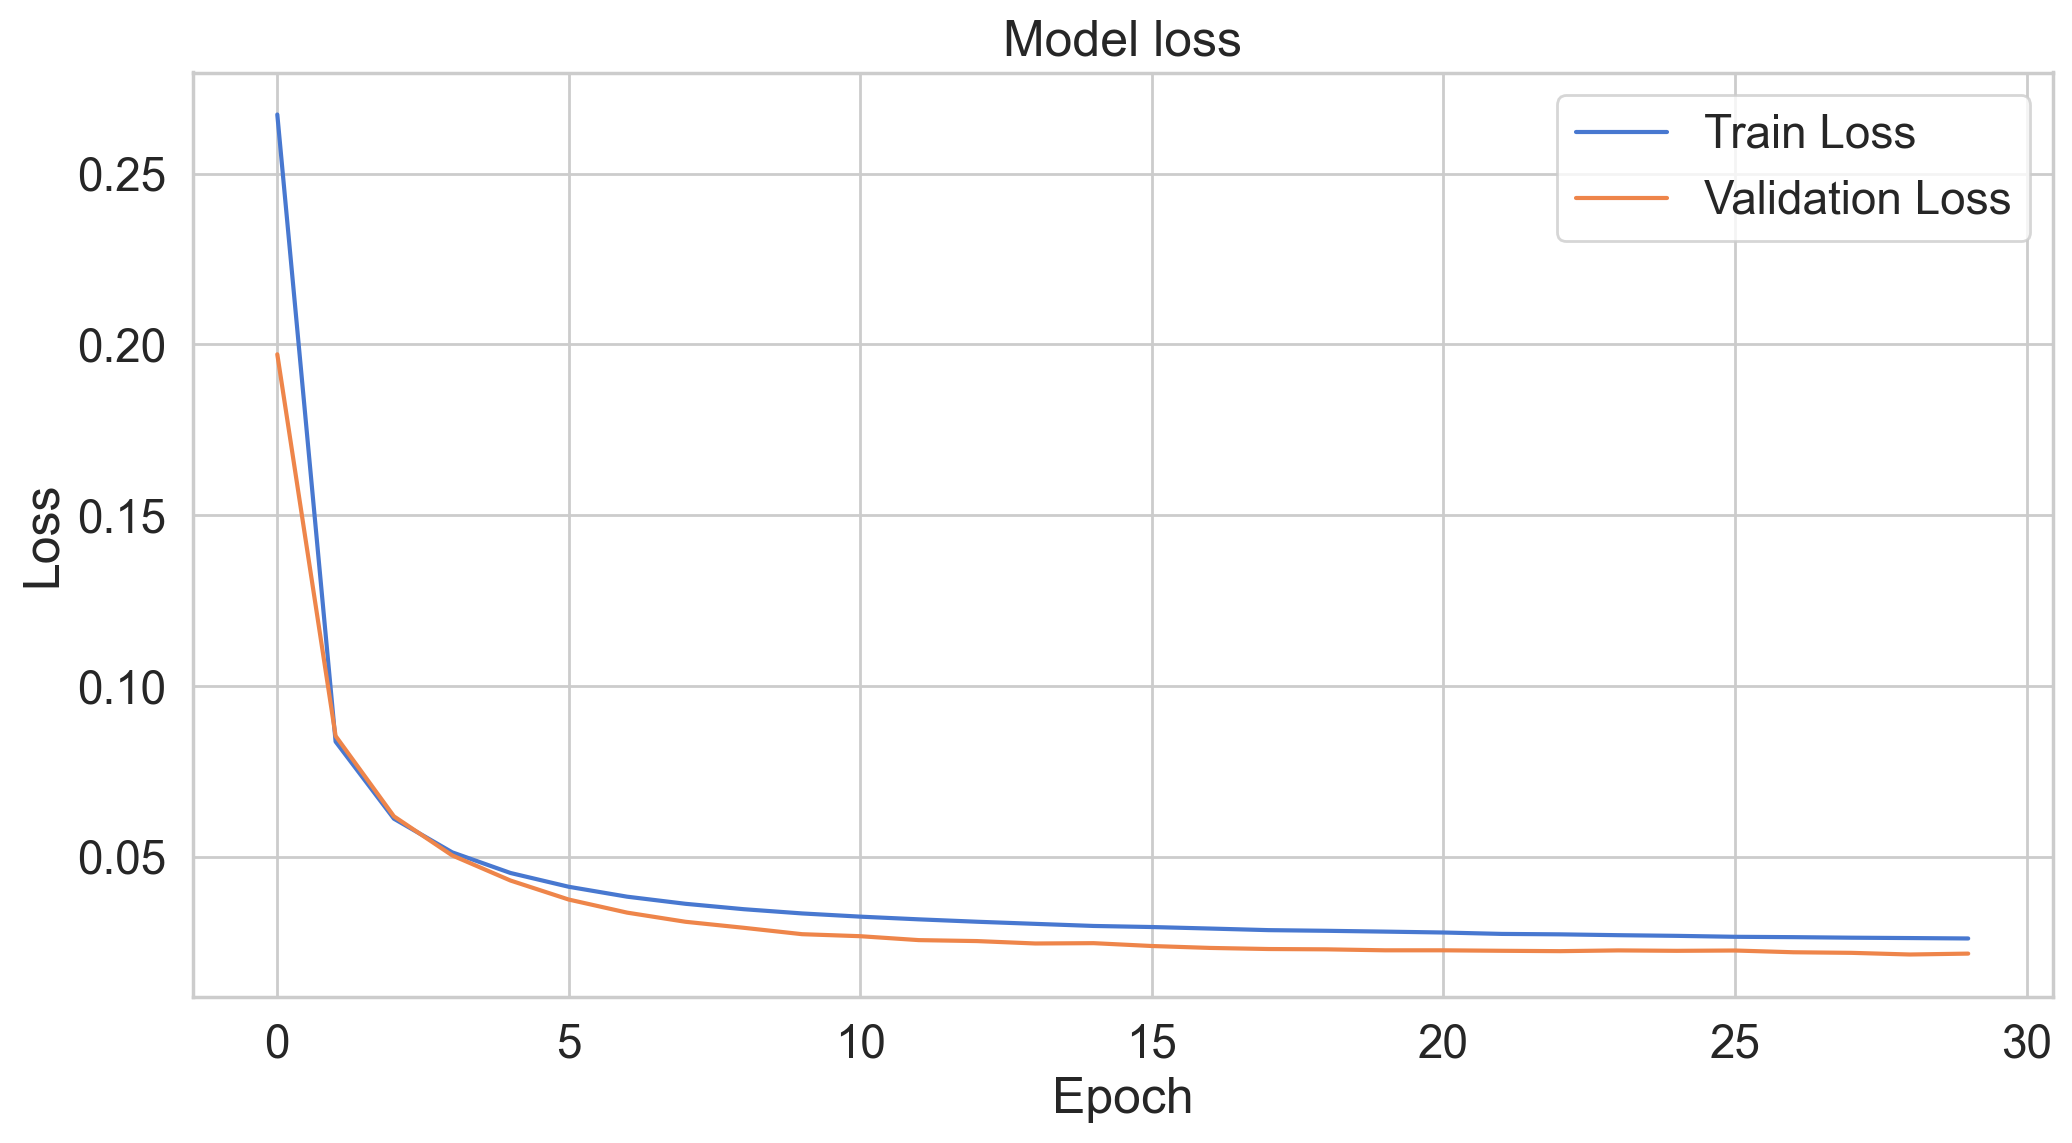

In [28]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [29]:
# Use the trained model to reconstruct the training sequences
train_predictions = model.predict(train_sequences)

# Calculate the reconstruction loss (Mean Absolute Error) for each sequence
reconstruction_errors = np.mean(np.abs(train_predictions - train_sequences), axis=1)

14035/14035 [==============================] - 53s 4ms/step


In [30]:
threshold = np.max(reconstruction_errors)
print(f"Reconstruction error threshold: {threshold}")

Reconstruction error threshold: 1.4676595270423705


In [31]:
# Use the trained model to reconstruct the test sequences
test_predictions = model.predict(test_sequences)

# Calculate the reconstruction loss (Mean Absolute Error) for each test sequence
test_reconstruction_errors = np.mean(np.abs(test_predictions - test_sequences), axis=1)

# Detect anomalies in the test set
anomalies = np.where(test_reconstruction_errors > threshold)[0]
print(f"Number of anomalies detected in the test set: {len(anomalies)}")

1009/1009 [==============================] - 4s 4ms/step
Number of anomalies detected in the test set: 3570


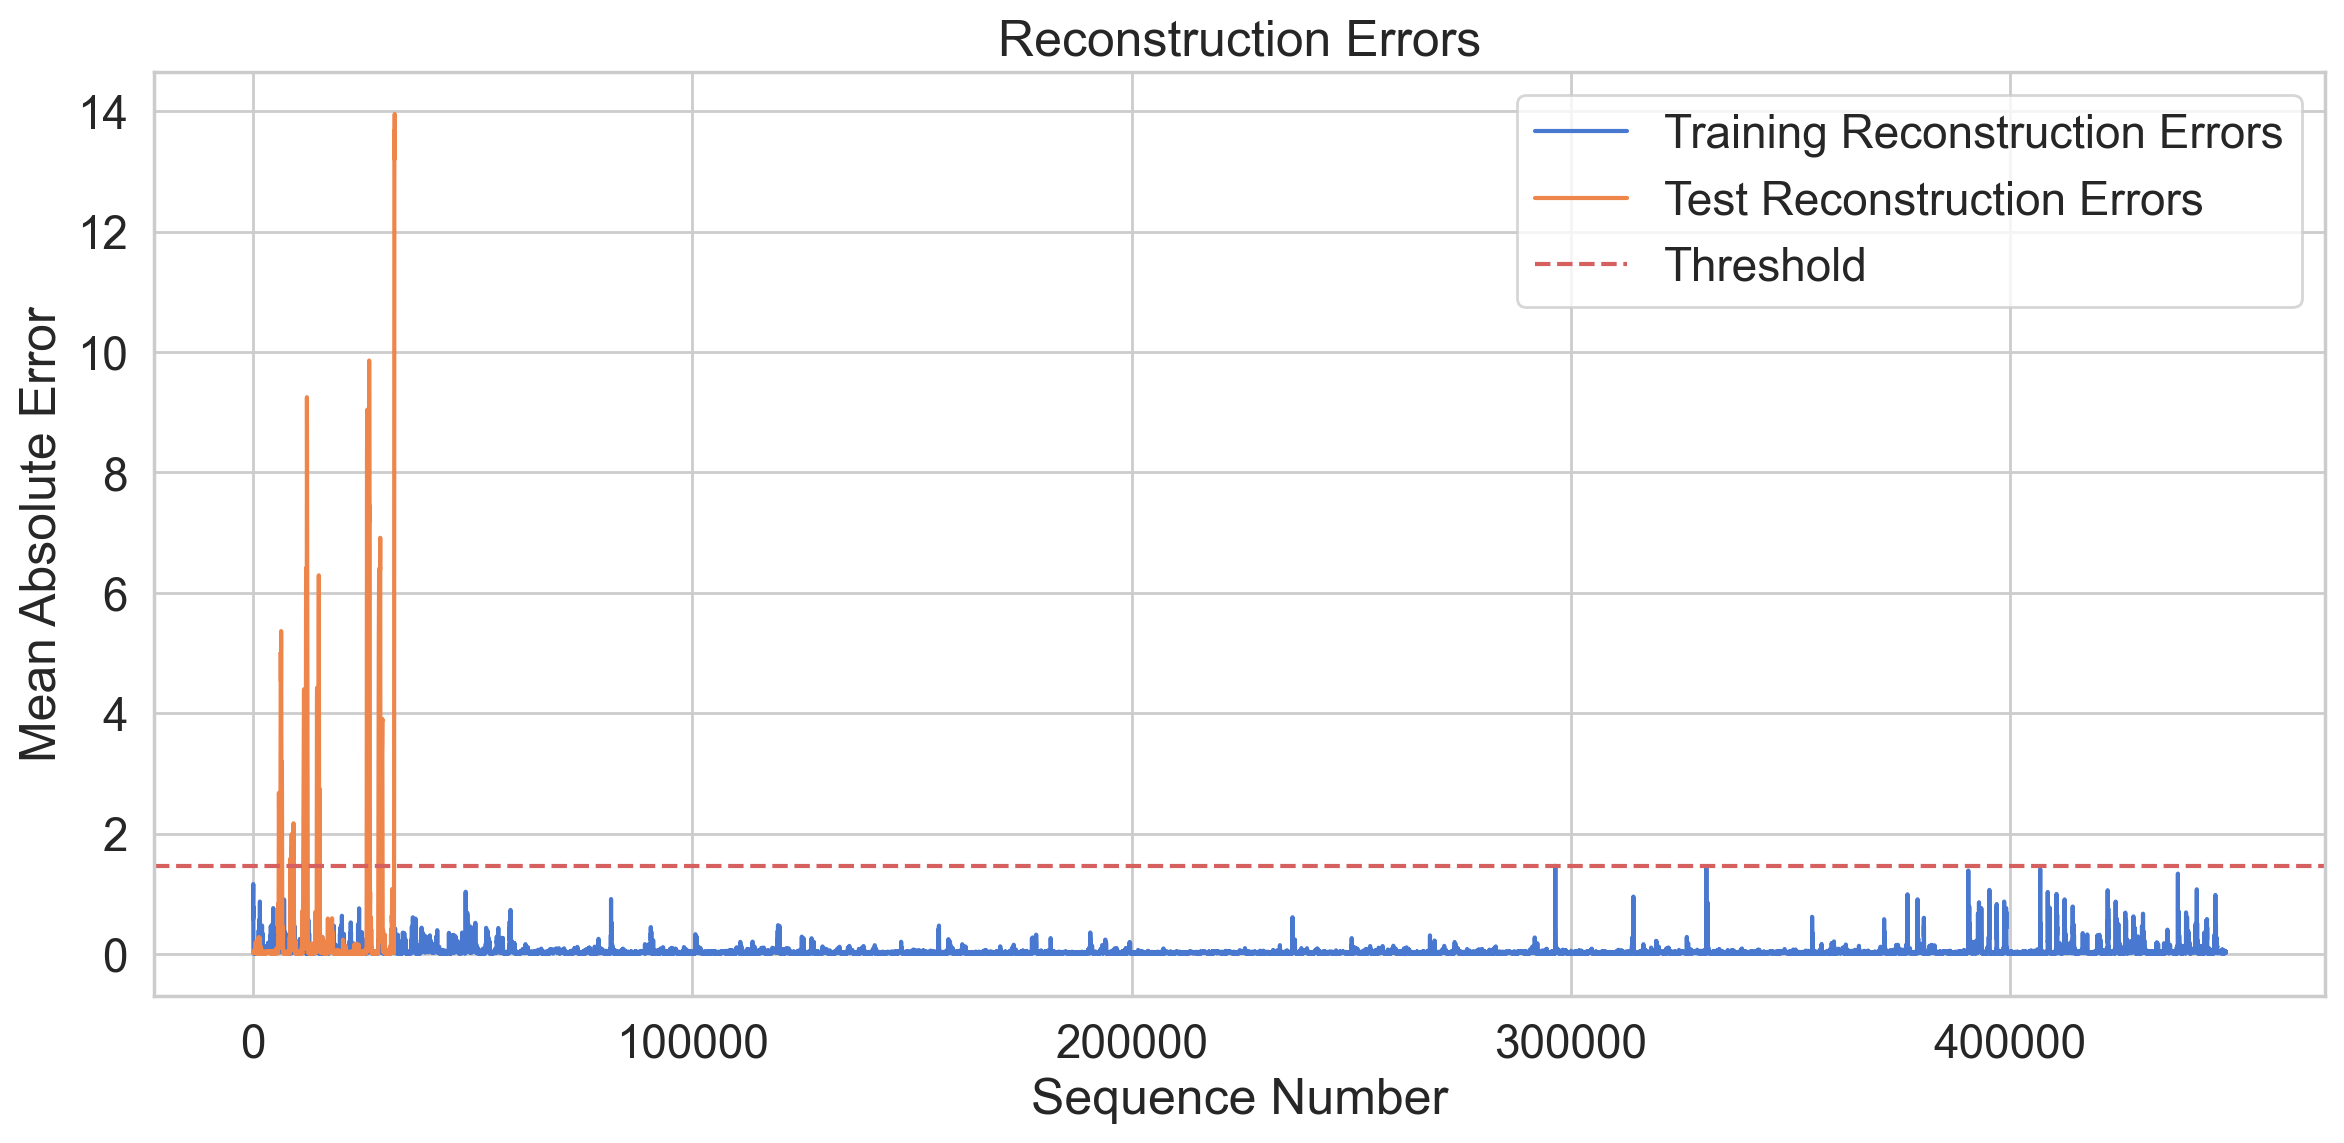

In [32]:
# Plotting the reconstruction errors for training and test data
plt.figure(figsize=(14, 6))
plt.plot(reconstruction_errors, label='Training Reconstruction Errors')
plt.plot(test_reconstruction_errors, label='Test Reconstruction Errors')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Errors')
plt.xlabel('Sequence Number')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

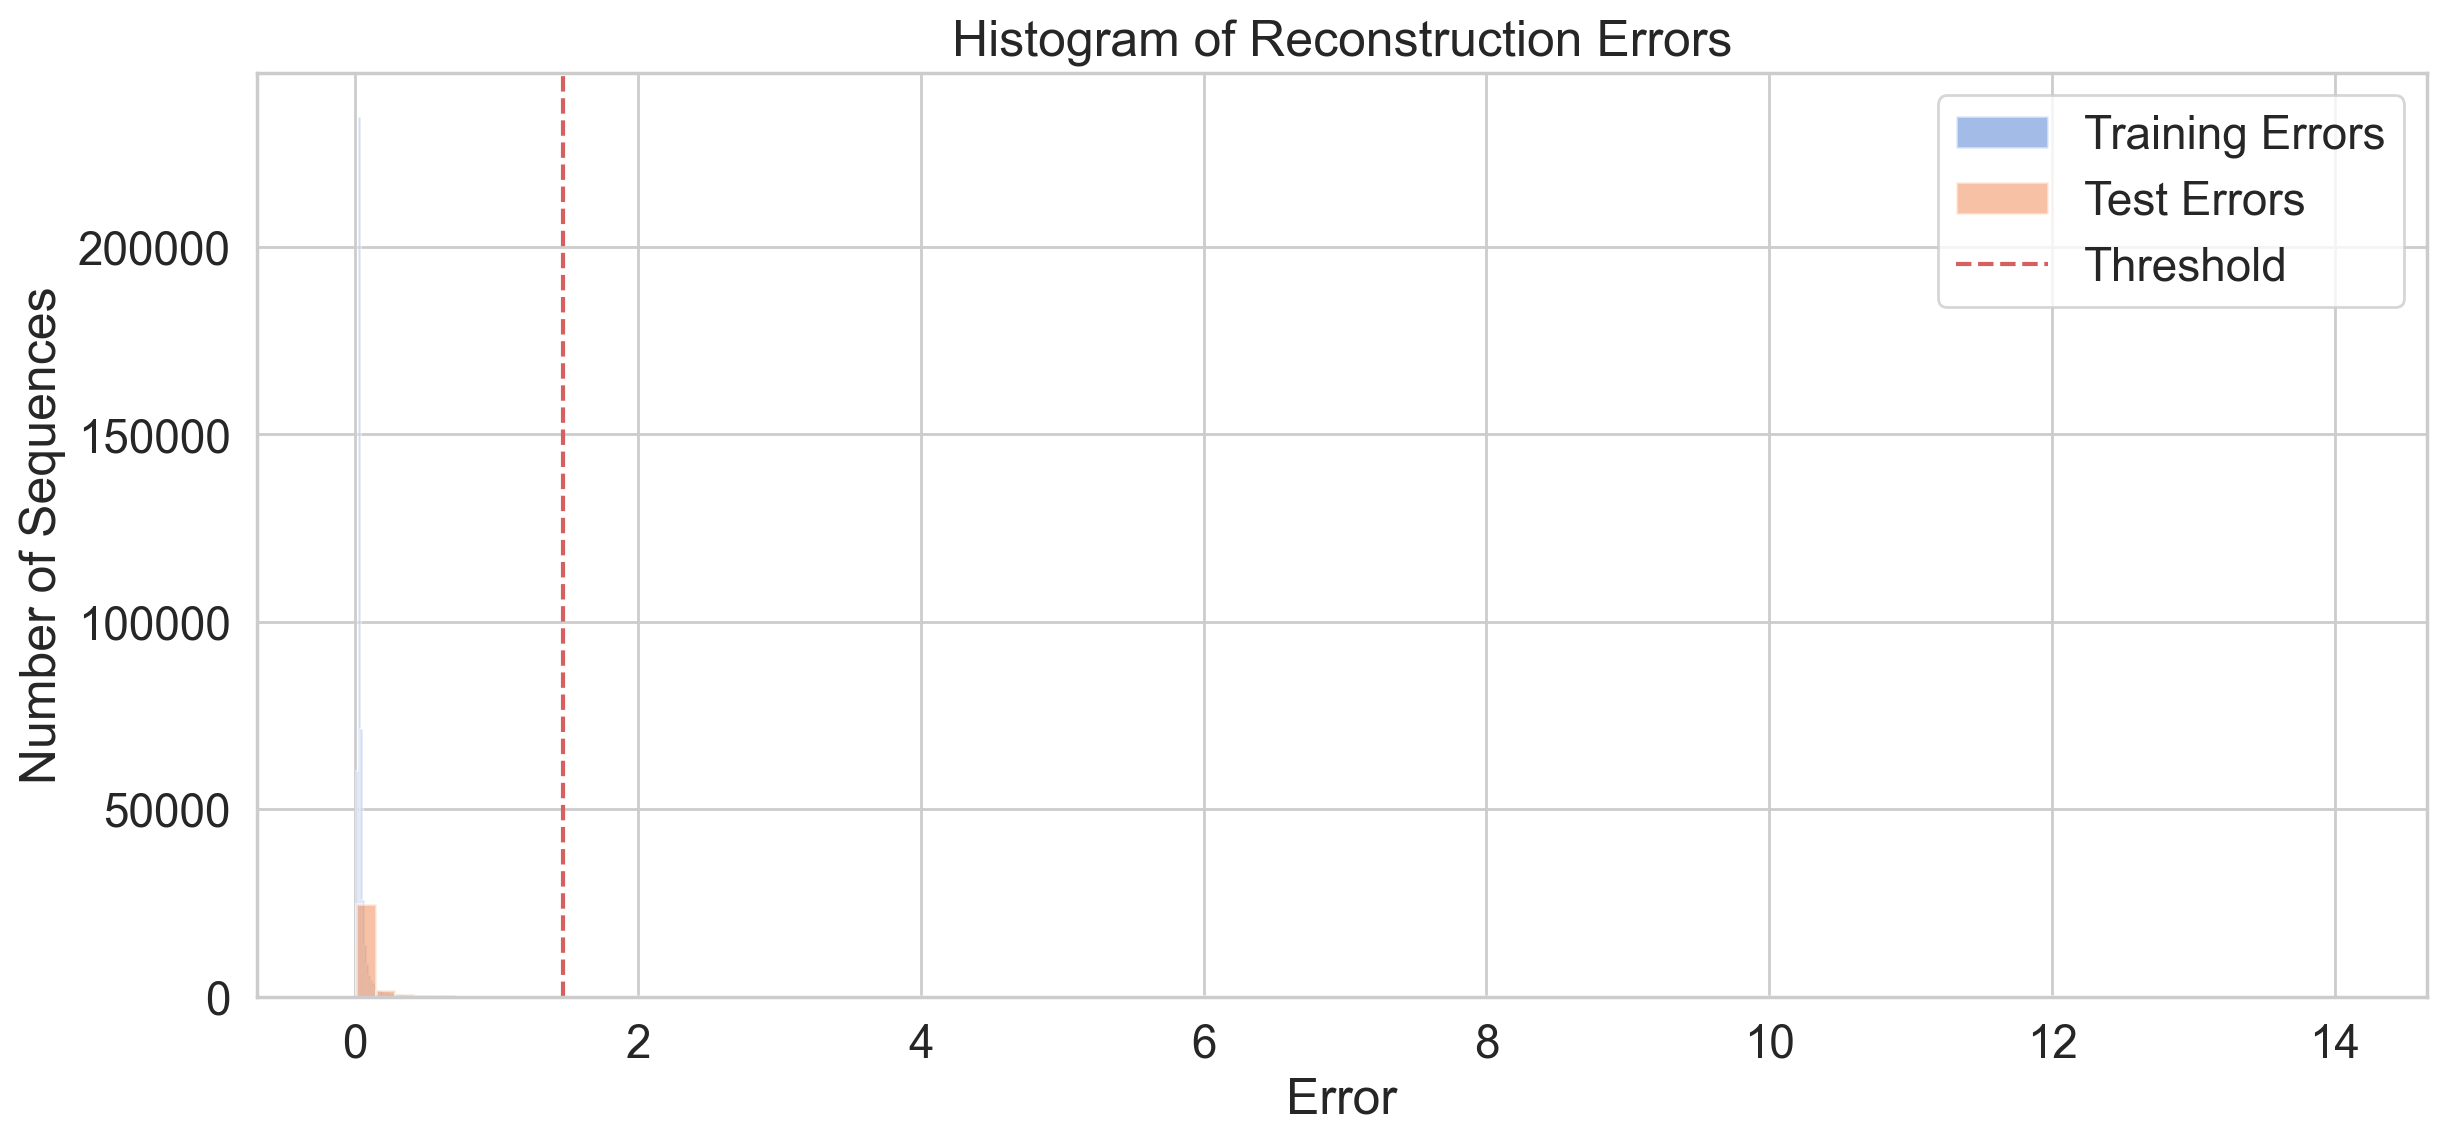

In [33]:
plt.figure(figsize=(14, 6))
plt.hist(reconstruction_errors, bins=100, alpha=0.5, label='Training Errors')
plt.hist(test_reconstruction_errors, bins=100, alpha=0.5, label='Test Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Error')
plt.ylabel('Number of Sequences')
plt.legend()
plt.show()

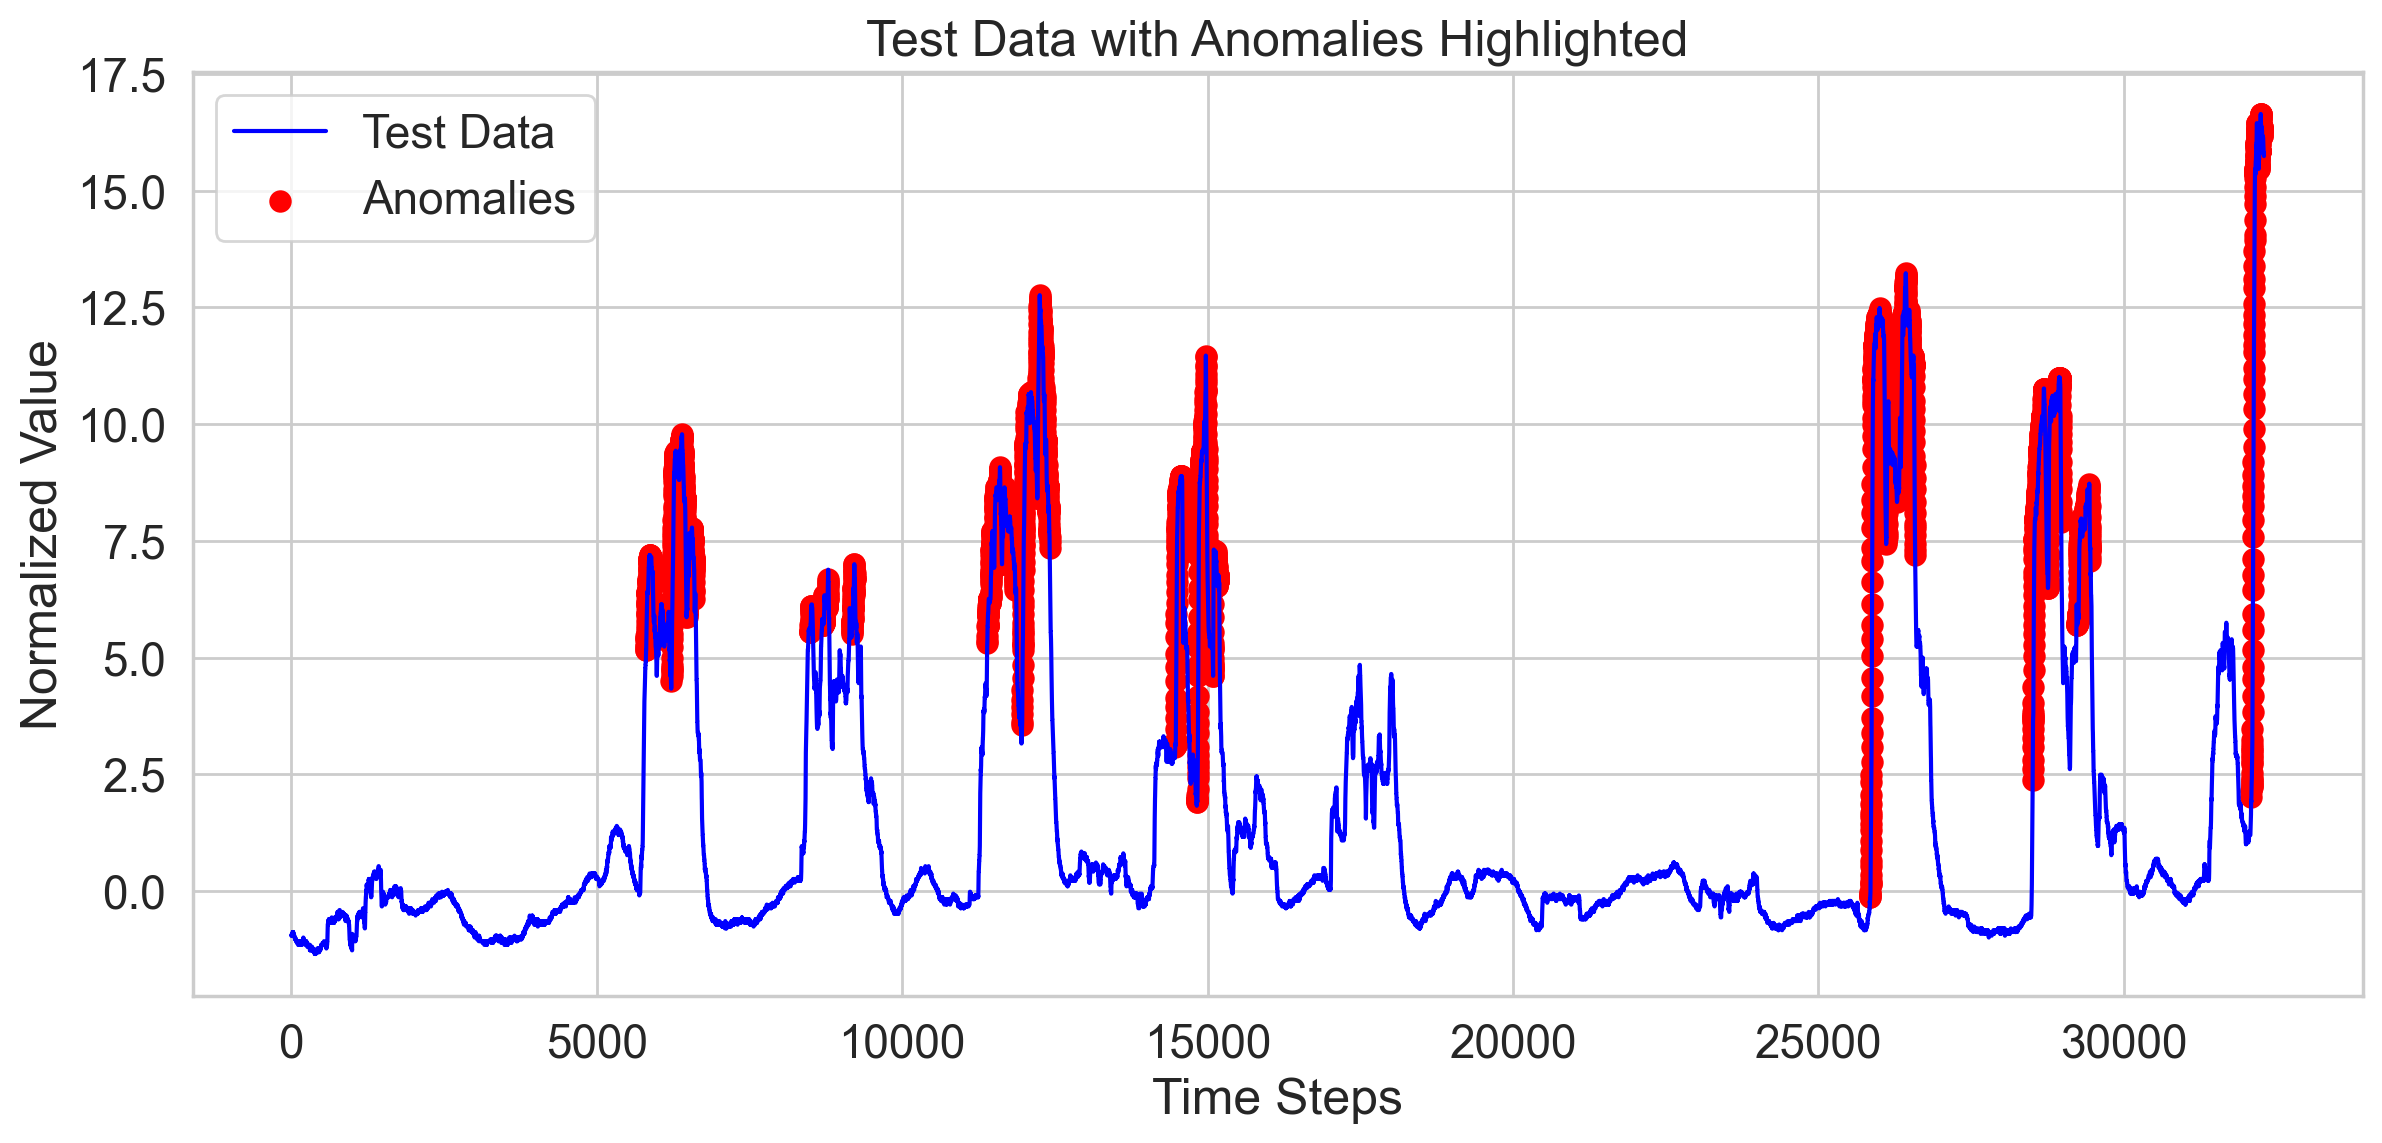

In [34]:
# Plotting the test data
plt.figure(figsize=(14, 6))
plt.plot(test_copy['v'].values, label='Test Data', color='blue')

# Highlighting the anomalies
plt.scatter(anomalies, test_copy['v'].values[anomalies], color='red', label='Anomalies', s=50)

plt.title('Test Data with Anomalies Highlighted')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

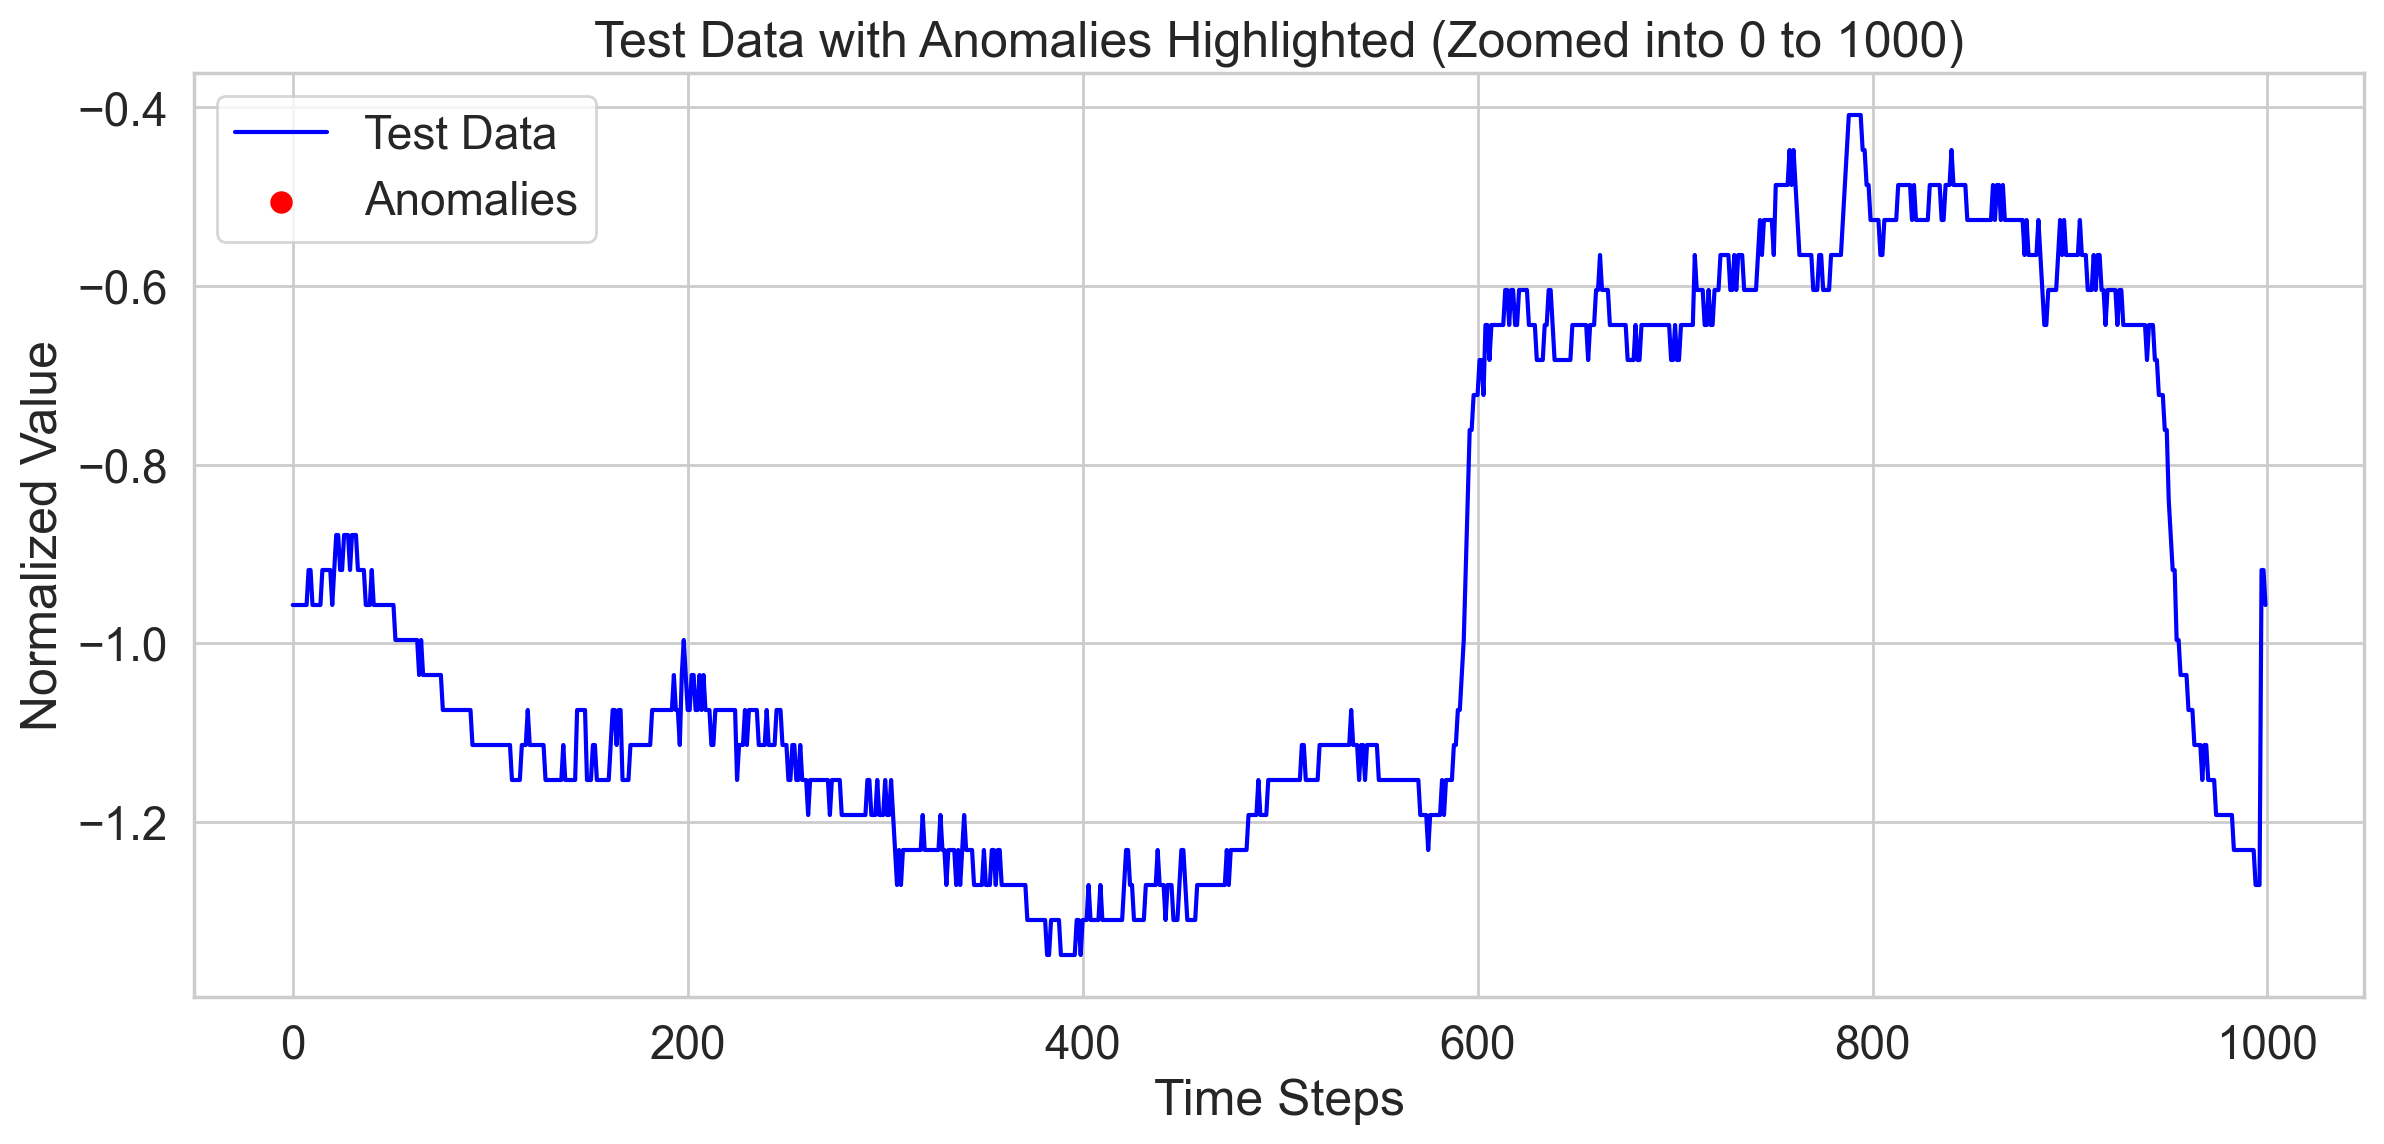

In [35]:
# Zooming into a specific region
start, end = 0, 1000  # Adjust these values based on the region you want to zoom into

plt.figure(figsize=(14, 6))
plt.plot(test_copy['v'].values[start:end], label='Test Data', color='blue')
plt.scatter(anomalies[(anomalies >= start) & (anomalies < end)], 
            test_copy['v'].values[anomalies[(anomalies >= start) & (anomalies < end)]], 
            color='red', label='Anomalies', s=50)

plt.title(f'Test Data with Anomalies Highlighted (Zoomed into {start} to {end})')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

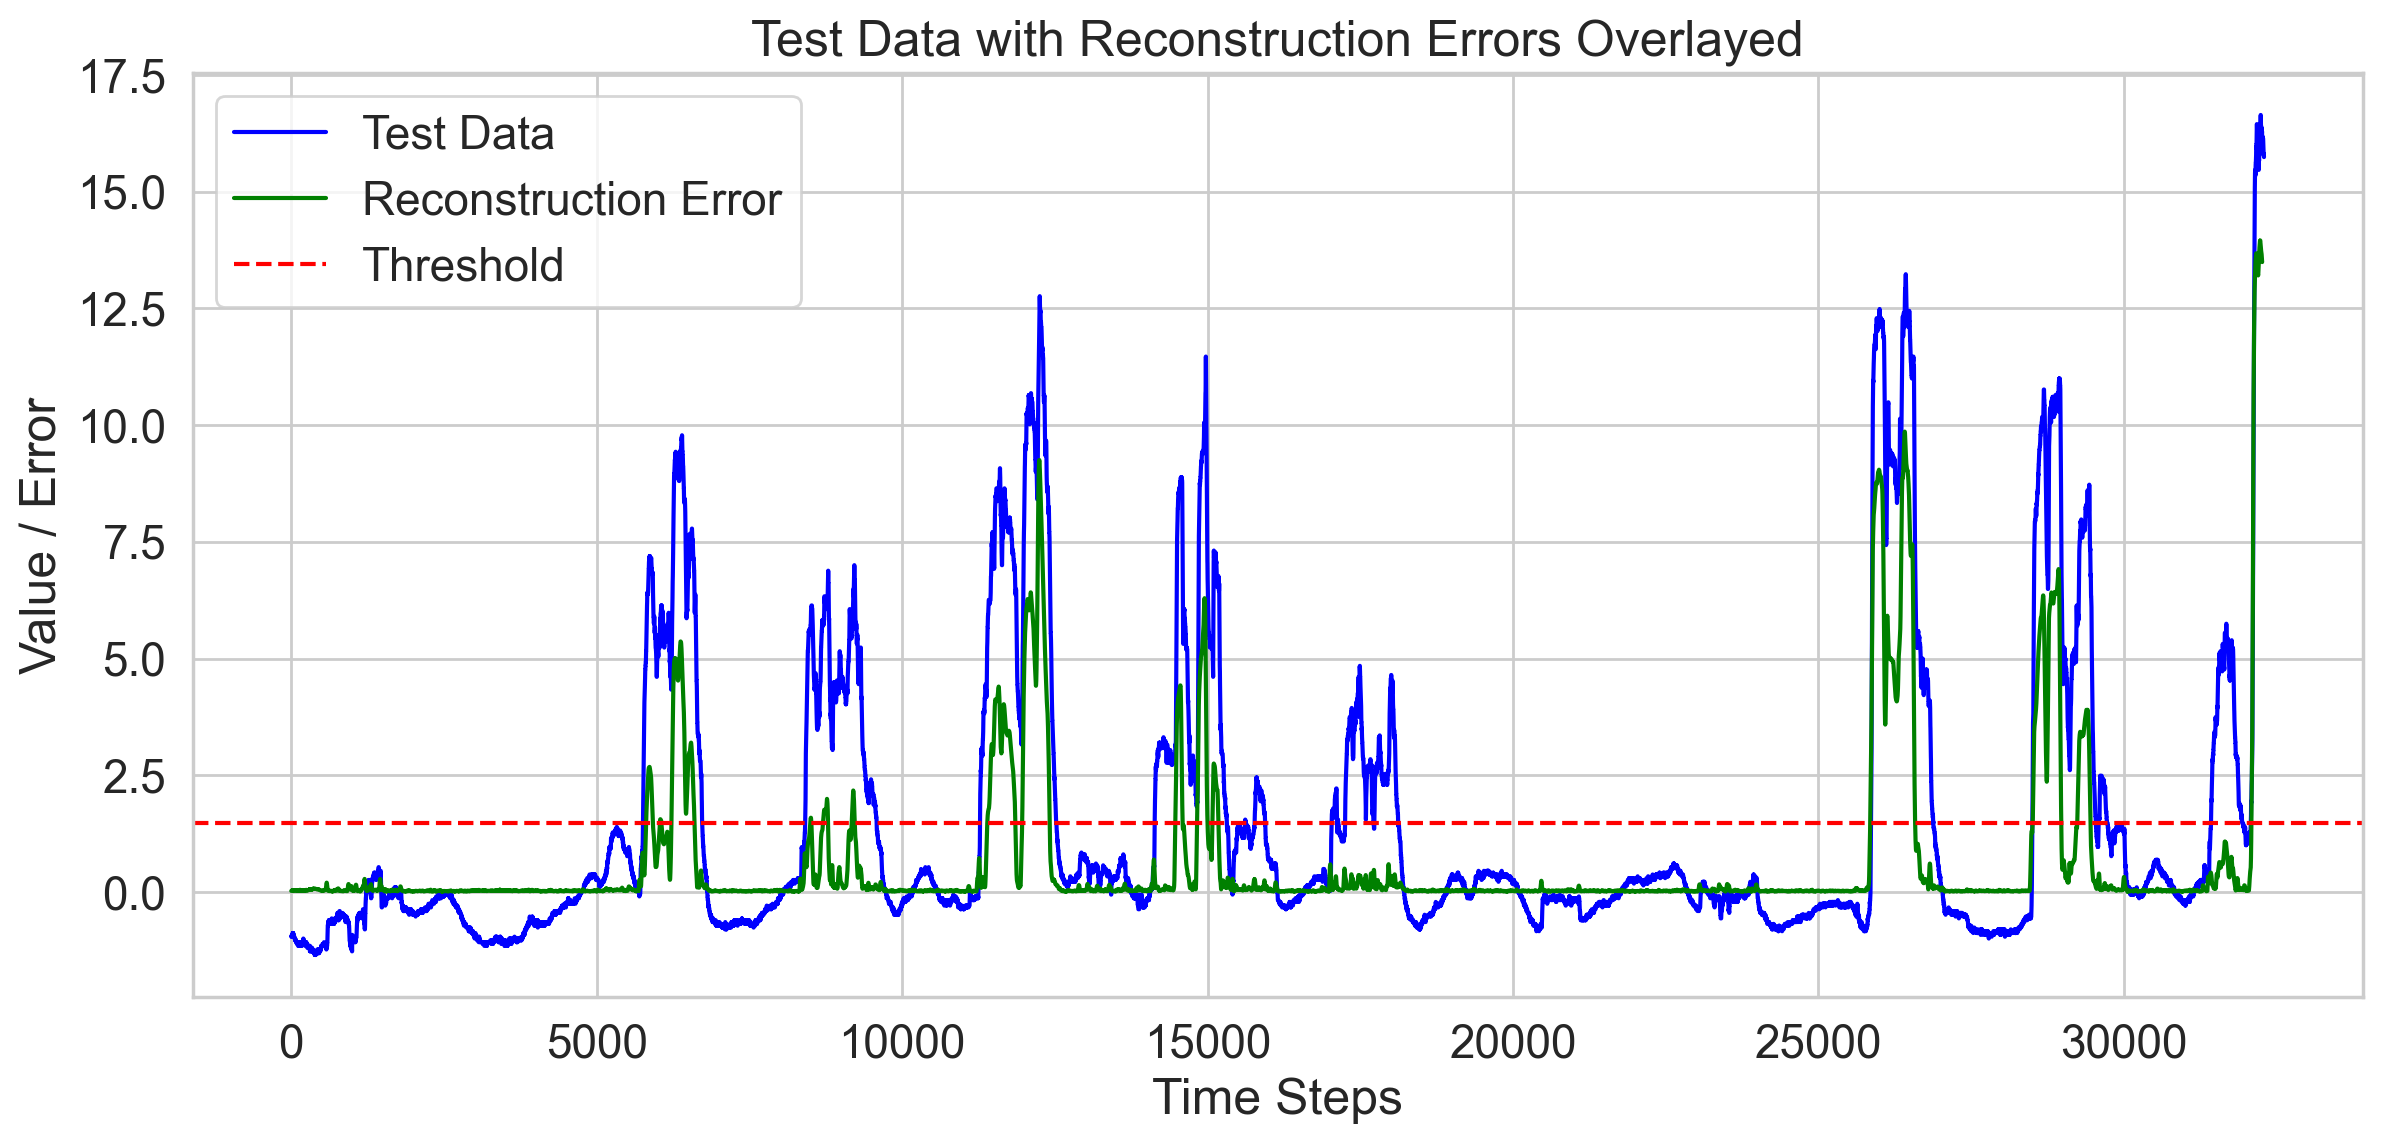

In [36]:
plt.figure(figsize=(14, 6))
plt.plot(test_copy['v'].values, label='Test Data', color='blue')
plt.plot(test_reconstruction_errors, label='Reconstruction Error', color='green')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Test Data with Reconstruction Errors Overlayed')
plt.xlabel('Time Steps')
plt.ylabel('Value / Error')
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have a DataFrame 'test_data' with 'v' (sensor values) and 'is_anomaly' (True for anomalies, False for normal)
true_labels = test_data['label']

# Assuming 'anomalies' contains the indices of detected anomalies in the test set
predicted_labels = np.zeros(len(test_data))
predicted_labels[anomalies] = 1

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9549465861588481
Precision: 0.9666666666666667
Recall: 0.7209108000835597
F1 Score: 0.8258944597343544


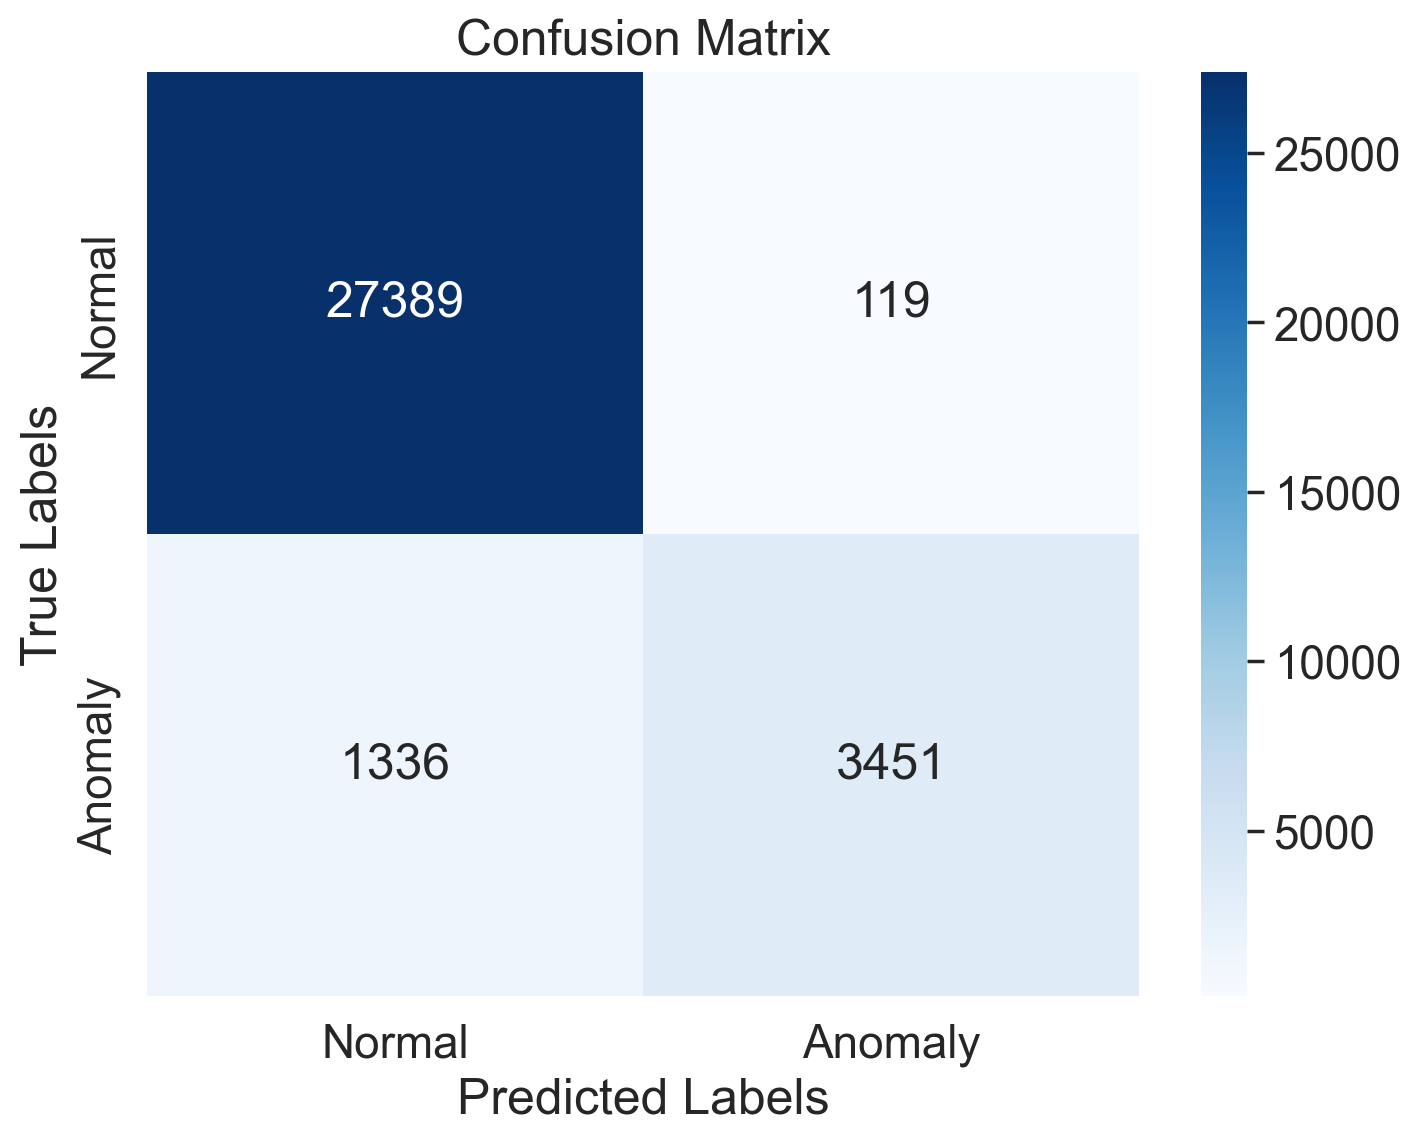

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
    
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()